## Задача 1

Реализовать класс для работы с линейной регрессией

In [27]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from typing import Optional, Tuple, Union

class MyLinearRegression:
    """
    Класс для реализации линейной регрессии с различными методами оптимизации и регуляризацией.
    
    Parameters
    ----------
    regularization : Optional[str], default=None
        Какую регуляризацию добавить к модели. Возможные значения:
        - None: без регуляризации
        - 'l1': L1 регуляризация (Lasso)
        - 'l2': L2 регуляризация (Ridge)
        - 'l1l2': комбинация L1 и L2 (Elastic Net)
    
    weight_calc : str, default='matrix'
        Каким образом вычислять вектор весов:
        - 'matrix': аналитическое решение через матрицы
        - 'gd': градиентный спуск
        - 'sgd': стохастический градиентный спуск
        Примечание: при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.
    
    lambda_1 : Optional[float], default=None
        Коэффициент L1 регуляризации. Обязателен при regularization='l1' или 'l1l2'.
    
    lambda_2 : Optional[float], default=None
        Коэффициент L2 регуляризации. Обязателен при regularization='l2' или 'l1l2'.
    
    batch_size : int, default=20
        Размер батча для стохастического градиентного спуска.
    
    alpha : float, default=0.01
        Шаг обучения (learning rate) для градиентного спуска.
    
    max_iter : int, default=5000
        Максимальное количество итераций градиентного спуска.
    
    early_stopping : float, default=0.0001
        Порог для ранней остановки: если норма градиента меньше этого значения, обучение прекращается.
    
    random_state : int, default=42
        Зерно для генератора случайных чисел (для воспроизводимости результатов).

    Attributes
    ----------
    coefs_ : Optional[np.ndarray]
        Вектор коэффициентов формы (n_features, 1), где n_features — количество признаков.
        Инициализируется как None, заполняется после вызова метода fit().
    
    intercept_ : Optional[float]
        Значение коэффициента intercept (свободный член).
        Инициализируется как None, заполняется после вызова метода fit().
    """

    def __init__(
        self, 
        regularization: Optional[str] = None, 
        weight_calc: str = 'matrix', 
        lambda_1: Optional[float] = None, 
        lambda_2: Optional[float] = None, 
        batch_size: int = 20, 
        alpha: float = 0.01, 
        max_iter: int = 5000, 
        early_stopping: float = 0.0001, 
        random_state: int = 42
    ) -> None:
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        if regularization in ['l1', 'l1l2'] and weight_calc == 'matrix':
            raise TypeError(f"При регуляризации 'l1' или 'l1l2' нельзя использовать параметр 'matrix'")
        
        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.alpha = alpha
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.random_state = random_state
        
        self.coefs_ = None
        self.intercept_ = None

    def _initialization(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Инициализация параметров модели и предобработка данных.
        
        Parameters
        ----------
        X : np.ndarray
            Матрица признаков формы (n_samples, n_features).
        
        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            Кортеж из двух массивов:
            - X_new : np.ndarray формы (n_samples, n_features + 1)
                Матрица признаков с добавленным столбцом единиц слева.
            - W : np.ndarray формы (n_features + 1,)
                Вектор инициализированных весов (случайные значения).
        """
        np.random.seed(self.random_state)
        X_new = np.hstack([np.ones((X.shape[0], 1)), X])
        W = np.random.uniform(size=X_new.shape[1])
        return X_new, W

    def _get_gradient(self, X: np.ndarray, Y: np.ndarray, W: np.ndarray) -> np.ndarray:
        """
        Вычисление градиента функции потерь (MSE) по весам.
        """
        n = X.shape[0]
        Y = Y.reshape(-1, 1)
        predictions = X @ W.reshape(-1, 1)
        # приводим градиент к 1D для удобной работы с регуляризацией
        grad = ((2 / n) * X.T @ (predictions - Y)).flatten()
        
        # Добавляем регуляризацию к градиенту (не трогаем интерцепт)
        if self.regularization == 'l1':
            grad[1:] += self.lambda_1 * np.sign(W[1:])
        elif self.regularization == 'l2':
            grad[1:] += 2 * self.lambda_2 * W[1:]
        elif self.regularization == 'l1l2':
            grad[1:] += self.lambda_1 * np.sign(W[1:]) + 2 * self.lambda_2 * W[1:]
        
        return grad

    def _matrix_regression(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """
        Аналитическое решение через матрицы.
        
        Parameters
        ----------
        X : np.ndarray
            Матрица признаков формы (n_samples, n_features).
        y : np.ndarray
            Вектор целевых значений формы (n_samples,) или (n_samples, 1).
        
        Returns
        -------
        Tuple[float, np.ndarray]
            Кортеж из двух значений:
            - intercept : float
                Значение коэффициента intercept (свободный член).
            - coefs : np.ndarray
                Вектор коэффициентов формы (n_features,).
        """
        X_with_ones = np.hstack([np.ones((X.shape[0], 1)), X])
        y = y.reshape(-1, 1)
        
        if self.regularization == 'l2':
            # Ridge регрессия: (X^T X + lambda * I)^(-1) X^T y
            n_features = X_with_ones.shape[1]
            identity = np.eye(n_features)
            identity[0, 0] = 0  # Не регуляризуем intercept
            Theta = inv(X_with_ones.T @ X_with_ones + self.lambda_2 * identity) @ X_with_ones.T @ y
        else:
            # Обычная линейная регрессия
            Theta = inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ y
        
        return Theta[0, 0], Theta[1:, 0]

    def _gd_regression(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """
        Градиентный спуск для оптимизации весов модели.
        
        Parameters
        ----------
        X : np.ndarray
            Матрица признаков формы (n_samples, n_features).
        y : np.ndarray
            Вектор целевых значений формы (n_samples,) или (n_samples, 1).
        
        Returns
        -------
        Tuple[float, np.ndarray]
            Кортеж из двух значений:
            - intercept : float
                Значение коэффициента intercept (свободный член).
            - coefs : np.ndarray
                Вектор коэффициентов формы (n_features,).
        """
        X_stacked, W = self._initialization(X)
        y = y.reshape(-1, 1)
        
        for i in range(self.max_iter):
            grad = self._get_gradient(X_stacked, y, W)
            grad_norm = np.linalg.norm(grad)
            if grad_norm < self.early_stopping:
                break
            W = W - self.alpha * grad
        
        return W[0], W[1:]

    def _sgd_regression(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """
        Стохастический градиентный спуск для оптимизации весов модели.
        
        Parameters
        ----------
        X : np.ndarray
            Матрица признаков формы (n_samples, n_features).
        y : np.ndarray
            Вектор целевых значений формы (n_samples,) или (n_samples, 1).
        
        Returns
        -------
        Tuple[float, np.ndarray]
            Кортеж из двух значений:
            - intercept : float
                Значение коэффициента intercept (свободный член).
            - coefs : np.ndarray
                Вектор коэффициентов формы (n_features,).
        """
        X_stacked, W = self._initialization(X)
        y = y.reshape(-1, 1)
        n_samples = X_stacked.shape[0]
        
        np.random.seed(self.random_state)
        for i in range(self.max_iter):
            # Случайная выборка батча
            indices = np.random.choice(n_samples, size=min(self.batch_size, n_samples), replace=False)
            X_batch = X_stacked[indices]
            y_batch = y[indices]
            
            # Градиент на батче
            grad = self._get_gradient(X_batch, y_batch, W)
            grad_norm = np.linalg.norm(grad)
            if grad_norm < self.early_stopping:
                break
            W = W - self.alpha * grad
        
        return W[0], W[1:]

    def fit(
        self, 
        X: Union[pd.DataFrame, np.ndarray], 
        y: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> 'MyLinearRegression':
        """
        Обучение модели линейной регрессии.
        
        Parameters
        ----------
        X : Union[pd.DataFrame, np.ndarray]
            Матрица признаков формы (n_samples, n_features).
            Может быть pandas DataFrame или numpy массив.
        y : Union[pd.DataFrame, pd.Series, np.ndarray]
            Вектор целевых значений формы (n_samples,).
            Может быть pandas DataFrame, Series или numpy массив.
        
        Returns
        -------
        MyLinearRegression
            Возвращает self для поддержки цепочки вызовов (method chaining).
        """
        # Преобразуем в numpy массивы
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()
        elif isinstance(y, pd.Series):
            y = y.values
        
        # Выбираем метод обучения
        if self.weight_calc == 'matrix':
            self.intercept_, self.coefs_ = self._matrix_regression(X, y)
        elif self.weight_calc == 'gd':
            self.intercept_, self.coefs_ = self._gd_regression(X, y)
        elif self.weight_calc == 'sgd':
            self.intercept_, self.coefs_ = self._sgd_regression(X, y)
        
        # Преобразуем coefs_ в нужный формат
        if isinstance(self.coefs_, np.ndarray):
            self.coefs_ = self.coefs_.reshape(-1, 1)
        else:
            self.coefs_ = np.array(self.coefs_).reshape(-1, 1)
        
        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray], ss: bool = True) -> np.ndarray:
        """
        Предсказание целевых значений для новых данных.
        
        Parameters
        ----------
        X : Union[pd.DataFrame, np.ndarray]
            Матрица признаков формы (n_samples, n_features).
            Может быть pandas DataFrame или numpy массив.
        ss : bool, default=True
            Параметр для совместимости (не используется).
        
        Returns
        -------
        np.ndarray
            Вектор предсказаний формы (n_samples,).
        
        Raises
        ------
        ValueError
            Если модель не была обучена (не вызван метод fit()).
        """
        if self.coefs_ is None or self.intercept_ is None:
            raise ValueError("Модель не обучена. Вызовите fit() перед predict().")
        
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Предсказание: y = X @ coefs_ + intercept_
        predictions = X @ self.coefs_ + self.intercept_
        
        return predictions.flatten()

    def score(
        self, 
        X: Union[pd.DataFrame, np.ndarray], 
        y: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> float:
        """
        Оценка качества модели с помощью коэффициента детерминации R².
        
        Parameters
        ----------
        X : Union[pd.DataFrame, np.ndarray]
            Матрица признаков формы (n_samples, n_features).
            Может быть pandas DataFrame или numpy массив.
        y : Union[pd.DataFrame, pd.Series, np.ndarray]
            Вектор целевых значений формы (n_samples,).
            Может быть pandas DataFrame, Series или numpy массив.
        
        Returns
        -------
        float
            Коэффициент детерминации R² (R-squared).
            Значение от -∞ до 1, где 1 означает идеальное соответствие модели данным.
            R² = 1 - (SS_res / SS_tot), где:
            - SS_res - сумма квадратов остатков (residual sum of squares)
            - SS_tot - общая сумма квадратов (total sum of squares)
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()
        elif isinstance(y, pd.Series):
            y = y.values
        
        y_pred = self.predict(X)
        y_mean = np.mean(y)
        
        # R² = 1 - (SS_res / SS_tot)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - y_mean) ** 2)
        
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0
        
        return r2

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import time


In [29]:
df = pd.read_csv("./Used_fiat_500_in_Italy_dataset.csv")
print(df.head(5))


    model  engine_power transmission  age_in_days      km  previous_owners  \
0     pop            69       manual         4474   56779                2   
1  lounge            69       manual         2708  160000                1   
2  lounge            69    automatic         3470  170000                2   
3   sport            69       manual         3288  132000                2   
4   sport            69       manual         3712  124490                2   

         lat       lon  price  
0  45.071079   7.46403   4490  
1  45.069679   7.70492   4500  
2  45.514599   9.28434   4500  
3  41.903221  12.49565   4700  
4  45.532661   9.03892   4790  


In [30]:
df.isna().sum()


model              0
engine_power       0
transmission       0
age_in_days        0
km                 0
previous_owners    0
lat                0
lon                0
price              0
dtype: int64

In [31]:
# Корреляционная матрица только по числовым признакам
corr_matrix = df.corr(numeric_only=True)
print("Матрица корреляции (числовые признаки):")
display(corr_matrix)



Матрица корреляции (числовые признаки):


,engine_power,age_in_days,km,previous_owners,lat,lon,price
engine_power,1.000000,0.241582,0.201903,0.015064,0.080793,-0.059394,-0.204472
age_in_days,0.241582,1.000000,0.752522,0.006737,0.006201,0.021197,-0.908123
km,0.201903,0.752522,1.000000,0.079167,-0.023324,0.113922,-0.777509
previous_owners,0.015064,0.006737,0.079167,1.000000,0.032807,-0.099468,-0.017751
lat,0.080793,0.006201,-0.023324,0.032807,1.000000,-0.780671,0.011575
lon,-0.059394,0.021197,0.113922,-0.099468,-0.780671,1.000000,-0.001025
price,-0.204472,-0.908123,-0.777509,-0.017751,0.011575,-0.001025,1.000000


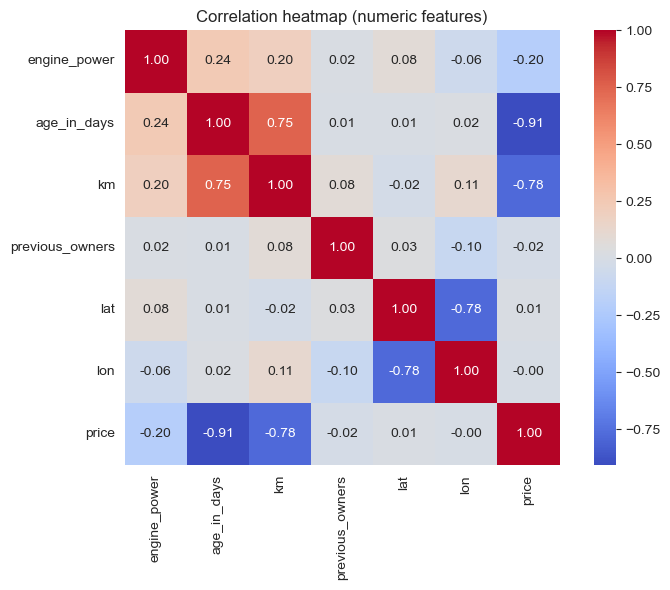

In [ ]:
# Тепловая карта корреляций
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()



In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size=0.2, random_state=42)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train.head()


,engine_power,age_in_days,km,previous_owners,lat,lon,model_pop,model_sport,model_star,transmission_manual
77,69,397,18324,2,45.436100,8.88787,False,False,False,True
220,69,4169,81900,2,45.443272,10.23021,False,False,False,True
297,69,548,82000,1,45.438301,10.99170,True,False,False,False
113,69,4414,149326,2,45.810711,9.08715,False,False,False,True
203,99,4535,120000,2,44.410389,8.93898,False,False,False,True


In [33]:
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
from typing import Dict, List, Any

# Настройка стиля для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


In [35]:
def time_execution(func):
    """Декоратор для замера времени выполнения функции"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        return result, execution_time
    return wrapper


In [41]:
# Сравнение GD: MyLinearRegression vs sklearn SGDRegressor с одинаковыми гиперпараметрами
alpha = 0.01
max_iter = 5000
early_stopping = 1e-4
random_state = 42

# Моя реализация
my_lr = MyLinearRegression(
    weight_calc='gd',
    regularization=None,
    alpha=alpha,
    max_iter=max_iter,
    early_stopping=early_stopping,
    random_state=random_state,
)

# Библиотечная реализация (без регуляризации, тот же шаг)
sk_lr = SGDRegressor(
    loss='squared_error',  # корректное имя квадратичной ошибки
    penalty=None,          # без регуляризации
    alpha=0.0,
    learning_rate='constant',
    eta0=alpha,
    max_iter=max_iter,
    tol=early_stopping,
    random_state=random_state,
)

(my_lr, my_fit_time) = time_execution(my_lr.fit)(X_train_scaled, y_train)
(sk_lr, sk_fit_time) = time_execution(sk_lr.fit)(X_train_scaled, y_train)

my_pred, my_pred_time = time_execution(my_lr.predict)(X_test_scaled)
sk_pred, sk_pred_time = time_execution(sk_lr.predict)(X_test_scaled)

my_r2 = r2_score(y_test, my_pred)
sk_r2 = r2_score(y_test, sk_pred)
my_mae = mean_absolute_error(y_test, my_pred)
sk_mae = mean_absolute_error(y_test, sk_pred)

print(f"MyLinearRegression (gd): fit {my_fit_time:.4f}s | predict {my_pred_time:.4f}s | R2={my_r2:.4f} | MAE={my_mae:.2f}")
print(f"sklearn SGDRegressor:    fit {sk_fit_time:.4f}s | predict {sk_pred_time:.4f}s | R2={sk_r2:.4f} | MAE={sk_mae:.2f}")


MyLinearRegression (gd): fit 0.0260s | predict 0.0000s | R2=0.8945 | MAE=559.22
sklearn SGDRegressor:    fit 0.0030s | predict 0.0000s | R2=-2.5152 | MAE=3341.51
